In [1]:
from pylab import *
mpl.rcParams['text.usetex'] = True
print('numpy version : ',np.__version__)
print('matplotlib version : ',mpl.__version__)

numpy version :  1.19.1
matplotlib version :  3.3.1


The map Jacobian $\textrm{J}_n$ at trajectory point $\vec{x}_n$ evolves the (unknown) matrices $\textrm{V}_n$ **of unit length** Lyapunov vectors

$$
    \textrm{J}_n \textrm{V}_n = \textrm{diag}\left(\vec{\mu}_{n}\right) \textrm{V}_{n+1}
$$

The map Jacobian $\textrm{J}_n$ at trajectory point $\vec{x}_n$ evolves the O(d) matrix $\textrm{Q}_n$ of orthogonal Lyapunov vectors

$$
    \textrm{J}_n \textrm{Q}_n = \textrm{Q}_{n+1}\textrm{R}_n
$$

where $\textrm{Q}_{n+1}\textrm{R}_n$ is the Gram-Schmidt QR decomposition of $\textrm{J}_n \textrm{Q}_n$, i.e. into an O(d) matrix $\textrm{Q}_{n+1}$ and an upper triangular matrix $\textrm{R}_n$.

With 

$$
    \textrm{Q}_{n+1}^\top\textrm{J}_n\textrm{Q}_n=\textrm{R}_{n} \qquad\textrm{and}\qquad
    \qquad \textrm{C}_{n} = \textrm{Q}_{n}^\top\textrm{V}_{n}
$$

follows

$$
    \textrm{R}_{n} \textrm{C}_{n} = \textrm{diag}\left(\vec{\mu}_{n}\right)\textrm{C}_{n+1}
$$


In [2]:
def ListDot(A,B) :
    """dot product of matrices or list of matrices
    input  : A[...,:L,:M], B[...,:M,:N]
    output : C[...,l,n] = sum_m A[...,l,m]*B[...,m,n]
    """
    return einsum('...ik,...kj->...ij',A,B)


def Inner(u,v) :
    """    
    takes two vectors of shapes (d) or (N,d) and returns their inner product
    """    
    return einsum('...i,...i->...',u,v)


def MaxNorm(M) :
    """
    returns maximum absolute value of the entries of M
    """
    return np.max(np.abs(M))
   

def normalize_collumns(A) :
    """
    takes an (d,n) array A and normalizes the collumns to length 1
    returns the normalized array (A is replaced) 
    and the normalization factors mu
    """
    (d,n) = A.shape
    mu=np.zeros(n)
    for i in range(n) :
        mu[i] = np.sqrt(A[:,i].dot(A[:,i]))
        A[:,i]/= mu[i]
    return A,mu

def Random_Orthogonal_Matrix(d) :
    """
    create a random O(d) matrix
    """
    M=np.random.randn(d,d)
    Q,R = np.linalg.qr(M)
    Q[:,0]*=sign(np.linalg.det(Q))
    return Q

def Random_UpTri_UnitLength(d) :
    """create positively oriented random upper triangular matrix with unit length collumn vectors"""
    C=np.random.randn(d,d)                     # gaussian random matrix
    for n in range(d-1) :
        C[n+1:,n]=0                            # cutting off lower tiangle
        C[:,n]/=np.sqrt(C[:,n].dot(C[:,n]))    # normalizing to one
        
    C[0,0]=1
    C[:,0]*=sign(np.linalg.det(C))             # put in positive orientation
    return C


def GSQR(M) :
    """performs Gram-Schmidt QR decomposition on an NxN matrix"""
    (N1,N2) = M.shape
    N=min(N1,N2)
    Q = np.array(M)
    R = np.zeros((N,N))
    for j in range(N) :
        for i in range(j) :
            for k in range(N) :
                Q[k,j] -= Q[k,i]*R[i,j]
        Q[:,j] /= np.sqrt(Q[:,j].dot(Q[:,j]))
        for i in range(j,N) :
            R[i,j]=0.0
            R[j,i]=Q[:,j].dot(M[:,i])
    return Q,R


In [3]:
def RK4Step(x,dt,f,Jf) :
    """Runge Kutta integration of dx/dt=f(x) and dJM/dt = Jf(x)JM (map Jacobian)"""
    k1=dt*f(x); Jk1 = dt*Jf(x)
    one=np.eye(*Jk1.shape)
    k2=dt*f(x+k1/2.0); Jk2 = dt*Jf(x+k1/2.0).dot(one+Jk1/2.0)
    k3=dt*f(x+k2/2.0); Jk3 = dt*Jf(x+k2/2.0).dot(one+Jk2/2.0)
    k4=dt*f(x+k3); Jk4 = dt*Jf(x+k3).dot(one+Jk3)
    xneu = x + (k1+2.0*k2+2.0*k3+k4)/6.0
    JM   = one+(Jk1+2.0*Jk2+2.0*Jk3+Jk4)/6.0
    return xneu,JM   

In [4]:
def GinelliFwdIteration(x0,Q0,Qprox0,M,N,verbose=False) :
    """
    Iterate x_{n+1} = M(x_n) N-1 steps forward
    M(x) returns step dt forward map x(t+dt) and map Jacobian JM(x,dt)
    
    Returns arrays x[0:N,:], Q[0:N,:,:], R[0:N,:,:] and DeltaQ[0:N]
    
    x[n,:] is state vector (x[0,:]=x0)
    Q[n,:,:] is field of O(d) matrices of orthogonal Lyapunov vectors (Q[0,:,:]=Q0)
    Qprox is independent matrix of orthogonal Lyapunov vectors (to monitor convergence)
    R[0:N,:,:] is field of upper triangular matrices
    DeltaQ[n] maxnorm distance ||abs(Q[n,:,:])-abs(Qprox)||_{max} 
    DeltaQ quantifies convergence in the forward direction
    """
    d=len(x0)
    x=np.zeros((N,d))              # trajectory
    Q=np.zeros((N,d,d))            # orthonormal Lyapunov (collumn) vectors
    R=np.zeros((N,d,d))            # map Jacobian in base Q
    DeltaQ=np.zeros(N)              # convergence error ( maxnorm(abs(Q)-abs(Qprox)) )
    
    xnow = x0
    
    Qnow  = Q0
    Qprox = Qprox0
    
    # Ginelli forward iterations :
    pctlast=-1
    for t in range(N) :
        
        x[t,:] = xnow
        DeltaQ[t]=MaxNorm(abs(Qnow)-abs(Qprox))   # convergence error

        pctnow=int(100*t/N)                         # progress counter
        if pctnow!=pctlast :
            pctlast=pctnow
            if verbose : print(pctnow,end='   \r')

        Q[t,:,:]=Qnow                   # save Qn
        xnext,MJnow = M(xnow)           # calculate dt ffwd mapping and map Jacobian
        Qnext,Rnow = GSQR(MJnow.dot(Qnow))    # Gram Schmidt QR decomposition
        Qprox,Rprox = GSQR(MJnow.dot(Qprox))
#        Qnext,Rnow = np.linalg.qr(MJnow.dot(Qnow))    # Gram Schmidt QR decomposition (using numpy)
#        Qprox,Rprox = np.linalg.qr(MJnow.dot(Qprox))
        R[t,:,:]=Rnow                   # save Rn
        Qnow=Qnext                      # prepare Qnow for next iteration
        xnow=xnext                      # prepare xnow for  next iteration
        
    return x,Q,R,DeltaQ

def GinelliBwdIteration(R,C0,Cprox0,verbose=False) :
    """
    Backward iteration of co-variant Lyapunov vectors C (in base Q)
    Takes arrays Q[0:N,:,:], R[0:N,:,:], C0[:,:] and Cprox0[:,:]
    Returns C[0:N,:,:], mu[0:N,:] and DeltaC[0:N]
    where C[n,:,:] = np.linalg.solve(R[n,:,:],C[n+1,:,:]) (C[-1,:,:]=C0)
    The mu[0:N,k] are the stretching factors in the directions 
    of the covariant Lyapunov vectors (mu_k = exp(\lambda_k dt))
    C and Cprox are upper triangular matrices of co-variant Lyapunov vectors (in base Q)
    DeltaC[n] maxnorm distance ||abs(C[n,:,:])-abs(Cprox)||_{max} 
    DeltaC quantifies convergence in the backward direction    
    """
    
    N,d,_ =  R.shape
    mu = np.zeros((N,d))
    
    DeltaC=np.zeros(N)              # convergence error (maxnorm(abs(C)-abs(Cprox)))

    C = np.zeros(R.shape)
    Cnow=C0
    Cprox=Cprox0
    
    Cnext = R[-1,:,:].dot(Cnow)
    Cnext,munow = normalize_collumns(Cnext)
    mu[-1,:]=munow

    pctlast=-1
    for t in range(N-1,0,-1) :
        C[t,:,:] = Cnow                                   # save Cnow
        Rlast = R[t-1,:,:]
        DeltaC[t]=MaxNorm(abs(Cnow)-abs(Cprox))
        
        pctnow=int(100*(N-t)/N)                         # progress counter
        if pctnow!=pctlast :
            pctlast=pctnow
            if verbose : print(pctnow,end='   \r')

        Clast = np.linalg.solve(Rlast,Cnow)  # calculate previous C
        Cprox = np.linalg.solve(Rlast,Cprox) # ... previous Cprox
        
        Clast,munow = normalize_collumns(Clast)
        Cprox,_ = normalize_collumns(Cprox)
        for n in range(d-1) :
            Clast[n+1:,n]=0                            # cutting off lower tiangle
            Cprox[n+1:,n]=0                           # cutting off lower tiangle
        mu[t-1,:]=1/munow

        Cnow=Clast                                          # prepare Cnow for next iteration
        

    C[0,:,:] = Cnow                                 # save Cnow
    DeltaC[0]=MaxNorm(abs(Cnow)-abs(Cprox))                   # add Cnow-Cprox distance to convergence error
    return C,mu,DeltaC

In [5]:
def Lyapunov_Vectors(x0,M,N) :
    """M(x(t)) = x(t+dt), JM(x,dt)    step dt map and map Jacobian
       Map M(x) is iterated N times with x0 as initial point. The map Jacobian is used to calculate
       co-variant Lyapunov vectors. Returns the matrices V[0:N,:,:] of Lyapunov (collumn) vectors,
       the streching factors mu[n,:] and the convergence errors DeltaQ and DeltaC of the 
       orthogonal Lyapunov vectors Q and the co-variant Lyapunov vectors C (V in base Q).
       Q, R and C are also returned if needed
    """

    d=len(x0)    # get system dimension
    
    # Q and Qprox are iterated forward together 
    # to monitor convergence of the orthogonal Lyapunov vectors
    Q0 = Random_Orthogonal_Matrix(d)
    Qprox0 = Random_Orthogonal_Matrix(d)
    
    print('# forward iterations ...')
    x,Q,R,DeltaQ = GinelliFwdIteration(x0,Q0,Qprox0,M,N,verbose=True)
    
    # C and Cprox are iterated backward together 
    # to monitor convergence of the co-variant Lyapunov vectors
    C0=Random_UpTri_UnitLength(d)    
    Cprox0=Random_UpTri_UnitLength(d)
    
    print('# backward iterations ...')
    C,mu,DeltaC, = GinelliBwdIteration(R,C0,Cprox0,verbose=True)
    
    V=ListDot(Q,C)

    print('# .done.')
    return x,V,mu,DeltaQ,DeltaC,Q,R,C


def Lyapunov_CoVectors(V) :
    """
    calculates the inverse matrices of the matrices V 
    of co-variant Lyapunov collumn vectors
    """
    UT = np.linalg.inv(V) # UT[n,:,:].dot(V[n,:,:])=eye(d)
    return UT

In [6]:
def RoesslerODE(x,a,b,c) :
    """
    ODE for Roessler Oscillator with parameters a,b and c
    """
    f=np.zeros(3)
    f[0]=-x[1]-np.exp(x[2])
    f[1]=x[0]+a*x[1]
    f[2]=b*np.exp(-x[2])+(x[0]-c)
    return f
    
def RoesslerJac(x,a,b) :
    """
    Jacobian of f(x) for the Roessler Oscillator 
    with parameters a and b (does not depend on c)
    """
    Jf=np.zeros((3,3))
    Jf[0,1]=-1.0
    Jf[0,2]=-np.exp(x[2])
    Jf[1,0]=1.0
    Jf[1,1]=a
    Jf[2,0]=1.0
    Jf[2,2]=-b*np.exp(-x[2])
    return Jf


Koper-Gaspard electrochemical oscillator model : 

[<a href="https://aip.scitation.org/doi/10.1063/1.462377">Koper MT, Gaspard P (1992) The modeling of mixed-mode and chaotic oscillations in electro-542chemical systems.The Journal of Chemical Physics 96(10):7797–7813.</a>]

$$
    \dot e = \frac{V_{ap}-e}{R_s}-120k(e)u
$$

$$
    \dot u = -1.25 \sqrt{d} k(e)u+2d(w-u)
$$

$$
    \dot w = 1.6d(2-3w+u)
$$

$$
    k(e) = 2.5\theta^2 + 0.01 \exp(0.5(e-30))
$$

$$
    \theta = 1 \qquad \textrm{for } e\le35 \qquad\textrm{(does not occur at used parameters)}
$$

$$
    \theta = \exp(-0.5(e-35)^2) \qquad \textrm{for } e>35
$$

----

rescaling

$$
    E = e -36 \qquad U = 20u \qquad W = 300w-200
$$

-----

substitution
$$
    \dot E = \frac{V_a-36-(e-36)}{R_s}-120k(e)U/20
$$

$$
    \dot U = -1.25\sqrt{d}k(e) U + 2d(20(W+200)/300-U)
$$

$$
    \dot W = 1.6 d(3(100\cdot 2-(W+200))+300U/20)
$$

$$
    k = 2.5\theta + 0.01\exp(0.5(E+6))
$$

$$
    \theta = \exp(-(E+1)^2)
$$

----

Koper-Gaspard ODEs in new variables

$$
    \dot E = \frac{V_a-36-E}{R_s}-6g(E)U
$$

$$
    \dot U = -1.25\sqrt{d}g(E) U + 2d(W/15-U+4/3-U)
$$

$$
    \dot W = 1.6 d(-3W+300U/20)
$$

$$
    g(E) = 2.5\exp(-(E+1)^2) + 0.01\exp(0.5(E+6))
$$

----

$$
    dk = 2.5 d\theta + 0.01\exp(0.5(E+6))/2
$$

$$
    d\theta = -2(E+1)\theta
$$

In [7]:
def KoperGaspardODE(x,Rs,Vap,d) :
    """
    electrochemical oscillator ODE model (3 variables, parameters Rs, Vap and d)
    """
    f=np.zeros(3)
    (E,U,W) = x[0],x[1],x[2]
    th = exp(-(E+1)**2)
    k = 2.5*th+0.01*exp(0.5*(E+6))
    
    f[0]=(Vap-E)/Rs - 6*k*U
    f[1]=-1.25*d**0.5*k*U + 2*d*(W/15-U+40/3)
    f[2]=1.6*d*(-3*W+15*U)
    return f

def KoperGaspardJac(x,Rs,Vap,d) :
    """
    Jacobian of f(x) for electrochemical oscillator ODE model
    """
    Jf=np.zeros((3,3))
    (E,U,W) = x[0],x[1],x[2]
    th = exp(-(E+1)**2)
    k = 2.5*th+0.01*exp(0.5*(E+6))
    dth=-2*(E+1)*th
    dk = 2.5*dth+0.01*exp(0.5*(E+6))/2
    
    Jf[0,0] = -1/Rs - 6*dk*U
    Jf[0,1] = - 6*k
    
    Jf[1,0] = -1.25*d**0.5*dk*U
    Jf[1,1] = -1.25*d**0.5*k-2*d
    Jf[1,2] = 2*d/15
    
    Jf[2,1] = 1.6*d*15
    Jf[2,2] = -3*1.6*d
    
    
    return Jf

amplitude $R$ and proto-phase $\vartheta_0$ and velocities $\dot R$ and $\dot\vartheta_0$

$$
    x = R\cos\vartheta_0, \qquad y = R\sin\vartheta_0
$$

$$
    \vec{r} = (x,y) = R(\cos\vartheta_0,\sin\vartheta_0) = R\vec{e}_r
$$

$$
    \dot{\vec{r}} = (\dot x,\dot y) = \dot R \vec{e}_r + \dot\vartheta_0 R\vec{e}_\vartheta
$$

$$
    \dot{\vec{r}}\cdot \vec{e}_\vartheta = \dot\vartheta_0 R = (\dot x,\dot y) \cdot \frac{1}{R}(-y,x) = \frac{x \dot y - y \dot x}{R}
$$

$$
    \dot \vartheta_0 = \frac{x \dot y - y \dot x}{R^2}
$$

$$
    \dot{\vec{r}}\cdot \vec{e}_r = \dot R = (\dot x,\dot y) \cdot \frac{1}{R}(x,y) = \frac{x \dot x + y \dot y}{R}
$$


In [8]:
# the following functions must be specified for each system individually
#
#

def theta_0(x) :
    """
    definition of geometric angle
    """
    th0 = arctan2(x[...,1],x[...,0])
    return th0

def grad_theta_0(x) :
    """
    gradient of theta_0
    """
    R0=R(x)
    gt0 = np.zeros(x.shape)
    gt0[...,0]=-x[...,1]/R0**2
    gt0[...,1]=x[...,0]/R0**2
    return gt0

def R(x) :
    """
    amplitude x=R\cos\vartheta_0, y=R\sin\vartheta_0
    """
    return sqrt(x[...,0]**2+x[...,1]**2)

def dR(x,f) :
    """
    time derivative of amplitude
    """
    return (f[...,0]*x[...,0]+f[...,1]*x[...,1])/R(x)

def grad_R(x) :
    """
    gradient of amplitude
    """
    gR=np.zeros(x.shape)
    R0=R(x)
    gR[...,0]=x[...,0]/R0
    gR[...,1]=x[...,1]/R0
    return gR

def dtheta_0(x,f) : 
    """
    angular velocity of proto-phase
    """
    dth0 = (f[...,1]*x[...,0]-f[...,0]*x[...,1])/R(x)**2
    return dth0

def q(kpar,x) :
    """
    angular correction function depending on a tuple kpar of parameters
    """
    R0=R(x)
    t0=theta_0(x)
    qval = R0**kpar[2]*x[...,2]**kpar[3]
    if kpar[0]==0 : qval*=cos(kpar[1]*t0)
    else : qval*=sin(kpar[1]*t0)
    return qval

def dq(kpar,x,f) :
    """
    speed of change of angular correction function
    """
    R0=R(x)
    dR0=dR(x,f)
    t0=theta_0(x)
    dt0 = dtheta_0(x,f)
    
    dqval = kpar[2]*dR0*R0**(kpar[2]-1)*x[...,2]**kpar[3] + R0**kpar[2]*kpar[3]*f[...,2]*x[...,2]**(kpar[3]-1)
    if kpar[0]==0 : dqval*=cos(kpar[1]*t0)
    else : dqval*=sin(kpar[1]*t0)
    if kpar[0]==0 :
        dqval-=R0**kpar[2]*x[...,2]**kpar[3]*kpar[1]*dt0*sin(kpar[1]*t0)
    else :
        dqval+=R0**kpar[2]*x[...,2]**kpar[3]*kpar[1]*dt0*cos(kpar[1]*t0)
    return dqval

def grad_q(kpar,x) :
    """
    gradient of angular correction function
    """
    R0=R(x)
    gR0=grad_R(x)
    t0=theta_0(x)
    gt0 = grad_theta_0(x)
    
    gq = np.zeros(x.shape)
    gq[...,0] = kpar[2]*gR0[...,0]*R0**(kpar[2]-1)*x[...,2]**kpar[3]
    gq[...,1] = kpar[2]*gR0[...,1]*R0**(kpar[2]-1)*x[...,2]**kpar[3]
    gq[...,2] = R0**kpar[2]*kpar[3]*x[...,2]**(kpar[3]-1)
    if kpar[0]==0 : 
        gq[...,0]=gq[...,0]*cos(kpar[1]*t0)-R0**kpar[2]*x[...,2]**kpar[3]*kpar[1]*gt0[...,0]*sin(kpar[1]*t0)
        gq[...,1]=gq[...,1]*cos(kpar[1]*t0)-R0**kpar[2]*x[...,2]**kpar[3]*kpar[1]*gt0[...,1]*sin(kpar[1]*t0)
        gq[...,2]*=cos(kpar[1]*t0)
    else : 
        gq[...,0]=gq[...,0]*sin(kpar[1]*t0)+R0**kpar[2]*x[...,2]**kpar[3]*kpar[1]*gt0[...,0]*cos(kpar[1]*t0)
        gq[...,1]=gq[...,1]*sin(kpar[1]*t0)+R0**kpar[2]*x[...,2]**kpar[3]*kpar[1]*gt0[...,1]*cos(kpar[1]*t0)
        gq[...,2]*=sin(kpar[1]*t0)
    return gq
    

def theta_sigma(kpar,sigma,x):
    """
    optimized geometric angle
    """
    thsgm = theta_0(x) 
    for know in kpar :
        thsgm+= sigma[know]*q(know,x)
    return thsgm

def dth_sigma(kpar,sigma,x,f) :
    """
    optimized angular velocity
    """
    dthsgm = dtheta_0(x,f) 
    for know in kpar :
        dthsgm += sigma[know]*dq(know,x,f)
    return dthsgm

def grad_th_sigma(kpar,sigma,x) :
    """
    optimized geometric phase gradient
    """
    gthsgm = grad_theta_0(x) 
    for know in kpar :
        gthsgm += sigma[know]*grad_q(know,x)
    return gthsgm

def MinimizeVarDth(kpar,x,f):
    """
    minimization of angular velocity variance
    """
    sigma = {know : 0.0 for know in kpar}
    
    kanz = len(kpar)
    ATA=np.zeros((kanz,kanz))
    ATb=np.zeros(kanz)

    qdot = [dq(know,x,f) for know in kpar]

    nu = dtheta_0(x,f)
    w0 = mean(nu)
    nu=nu-w0

    for i in range(kanz) :
        ATb[i] = -mean(qdot[i]*nu)
        for j in range(i,kanz) :
            ATA[i,j] = mean(qdot[i]*qdot[j])
            ATA[j,i] = ATA[i,j]

    sgm = np.linalg.solve(ATA,ATb)
    for i in range(len(sgm)) : sigma[kpar[i]]=sgm[i]
    return sigma

def MinimizeVarGth(kpar,x,V,f,Z) :
    """
    Find geometric phase approximation for given Lyapunov vectors and phase sensitivity Z
    V = [f,v1,v2,...], Z.dot(f)=1 and Z.dot(vk)=0 for vk!=f
    Note, the sequence of collumn vectors doesn't matter, but f must be one of the collumn vectors
    The lengths of the vectors vk (!=f) has to be chosen beforehand
    """
    sigma = {know : 0.0 for know in kpar}
    
    kanz = len(kpar)
    ATA=np.zeros((kanz,kanz))
    ATb=np.zeros(kanz)
    
    dth0 = dtheta_0(x,f)
    w0 = mean(dth0)
    gq = [einsum('ni,nik->nk',grad_q(know,x),V).ravel() for know in kpar]

    gth0 = grad_theta_0(x)
    

    b=einsum('ni,nik->nk',w0*Z-gth0,V)
    b=b.ravel()
    
    for i in range(kanz) :
        ATb[i] = mean(gq[i]*b)
        for j in range(i,kanz) :
            ATA[i,j] = mean(gq[i]*gq[j])
            ATA[j,i] = ATA[i,j]

    sgm = np.linalg.solve(ATA,ATb)
    for i in range(len(sgm)) : sigma[kpar[i]]=sgm[i]
    return sigma
    

def WrapPhase(th,th0=-pi) :
    """
    returns phases in an interval [th0,th0+2pi]
    """
    return mod(th-th0,2*pi)+th0

In [9]:
N=1500000 # sufficiently large number of time steps


dphi=0.001 # sufficiently small time step

#x0 = np.random.randn(3)

x0=np.zeros(3)
x0[0]=np.random.randn()*0.1
x0[1]=5+np.random.randn()*0.01
x0[2]=25+np.random.randn()*0.01

# some parameters for chaotic Roessler oscillator
#a=0.1
#b=0.1
#c=11.0
#-----------------
#a=0.25
#b=0.9
#c=6.0
#-----------------

Rs=0.02
Vap=0.738
d=0.119

f = lambda x : KoperGaspardODE(x,Rs,Vap,d)
Jf = lambda x : KoperGaspardJac(x,Rs,Vap,d)
M = lambda x : RK4Step(x,dphi,f,Jf)               #  map and map jacobian for time step dphi

x,V,mu,DeltaQ,DeltaC,*_ = Lyapunov_Vectors(x0,M,N)

fn=np.zeros(x.shape)
print("# re-calculating f_n...")
for n in range(N) : fn[n,:]=f(x[n,:])

print("# .done.")    

# forward iterations ...
# backward iterations ...
# .done.
# re-calculating f_n...
# .done.


<IPython.core.display.Javascript object>


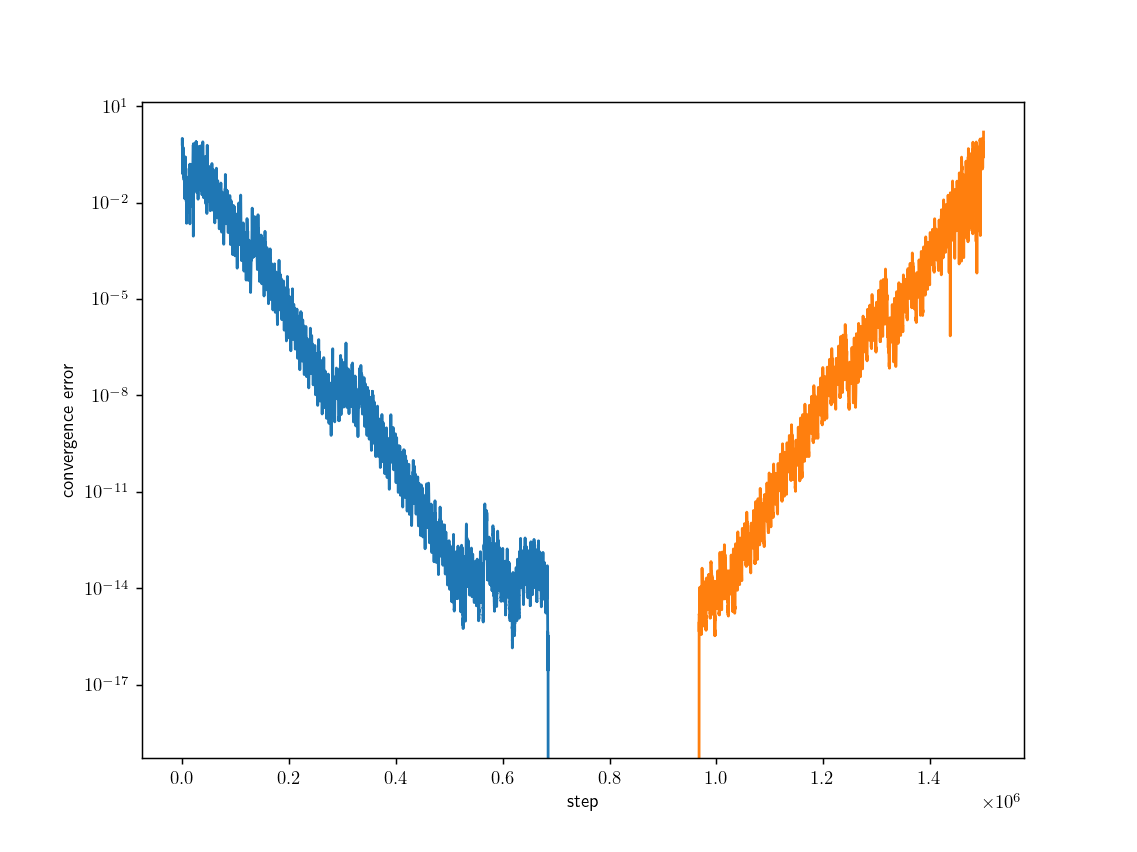

In [10]:
# plot convergence errors for selection of time interval
%matplotlib notebook
semilogy(DeltaQ)
semilogy(DeltaC)
xlabel('step')
ylabel('convergence error')
show()

<IPython.core.display.Javascript object>


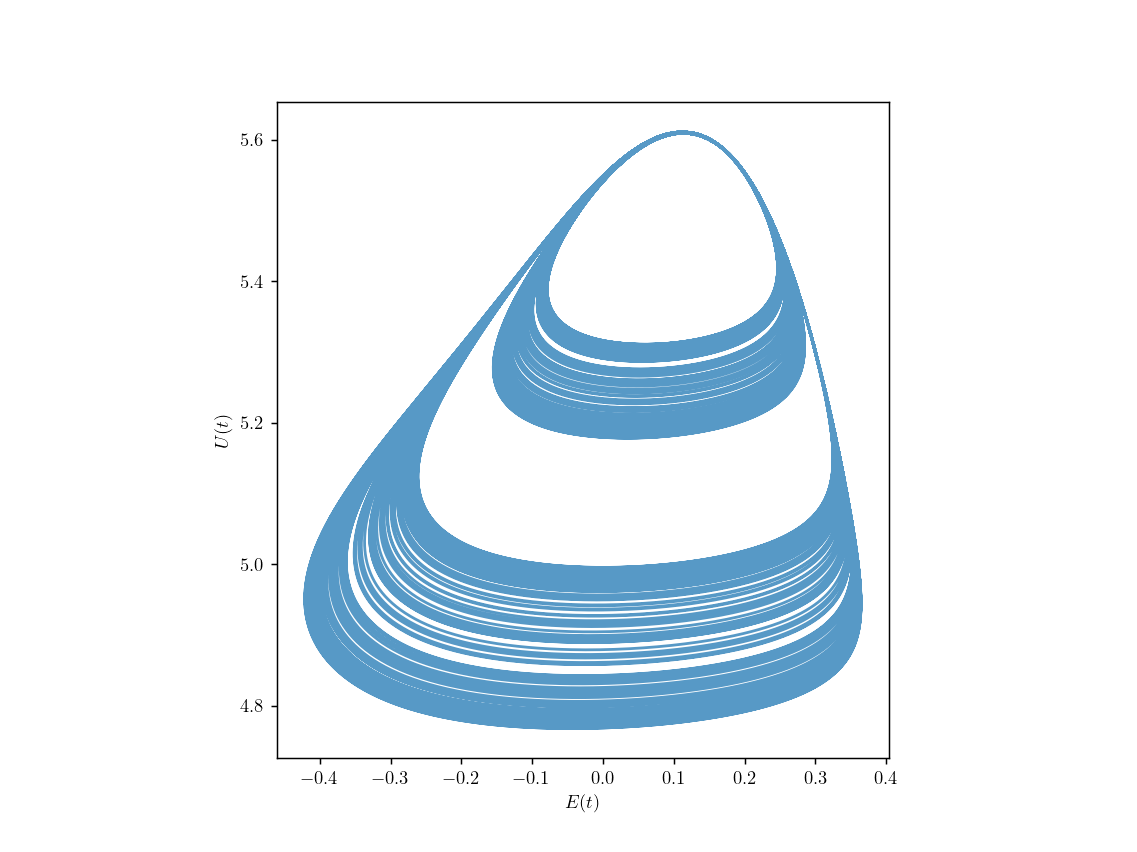

In [11]:
# select time interval where co-variant Lyapunov vectors have converged
n0=500000
n1=1000000

%matplotlib notebook

plot(x[n0:n1,0],x[n0:n1,1],alpha=0.75)  # trajectory over selected time interval
axis('scaled')
xlabel(r'$E(t)$')
ylabel(r'$U(t)$')
show()

In [12]:
print("# calculating phase sensitivity Z(x)")
UT = Lyapunov_CoVectors(V)
Z = np.array(UT[n0:n1,1,:])
Zf = einsum('ti,ti->t',Z,fn[n0:n1,:])
Z = einsum('ti,t->ti',Z,1/Zf)
#Z[:,0]/=Zf
#Z[:,1]/=Zf
#Z[:,2]/=Zf

# calculating phase sensitivity Z(x)


In [13]:
# delay in time steps for delay embedding
k1=300
k2=300


# delay coordinates
E1 = x[n0+k1+k2:n1,0]
E2 = x[n0+k2:n1-k1,0]
E3 = x[n0:n1-k1-k2,0]

# time derivative of delay coordinates
f1 = fn[n0+k1+k2:n1,0]
f2 = fn[n0+k2:n1-k1,0]
f3 = fn[n0:n1-k1-k2,0]

# trajectory and time derivative in delay coordinates
xdel = np.array([E1,E2,E3]).T
fdel = np.array([f1,f2,f3]).T

# tuple of integers representing the angular correction functions q_k
kpar = tuple((pm,k,l,m) for m in range(4) for l in range(4) for k in range(7) for pm in range(2)
            if not ((pm==1 and k==0) or (pm,k,l,m)==(0,0,0,0)))

print(len(kpar)) # number of parameters in the llsq minimization problem

207


In [14]:
print('calculating proto phase and phase velocity...')
th0 = WrapPhase(theta_0(xdel))
dth0 =dtheta_0(xdel,fdel)
print('minimum :',np.min(dth0)) # should be positive, but that is not so important

calculating proto phase and phase velocity...
minimum : 0.08658195949337984


In [15]:
# generate a color map for the geometric proto-phase
L=len(th0)
c0=np.zeros((L,4))
nsec=100
for s in range(nsec) :
    s0idx = np.nonzero((s*2*pi/nsec<=mod(th0,2*pi)) * ((s+1)*2*pi/nsec>mod(th0,2*pi)))    
    c0[s0idx,:]=np.random.random(4)

In [16]:
# geometric protophase theta_0 (in delay coordinates)

%matplotlib notebook
scatter(xdel[:,0],xdel[:,1],s=0.2,c=c0)
plot(0,0,'rx')
axis('scaled')
xlabel(r'$E(t)$')
ylabel(r'$E(t-0.3)$')
show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


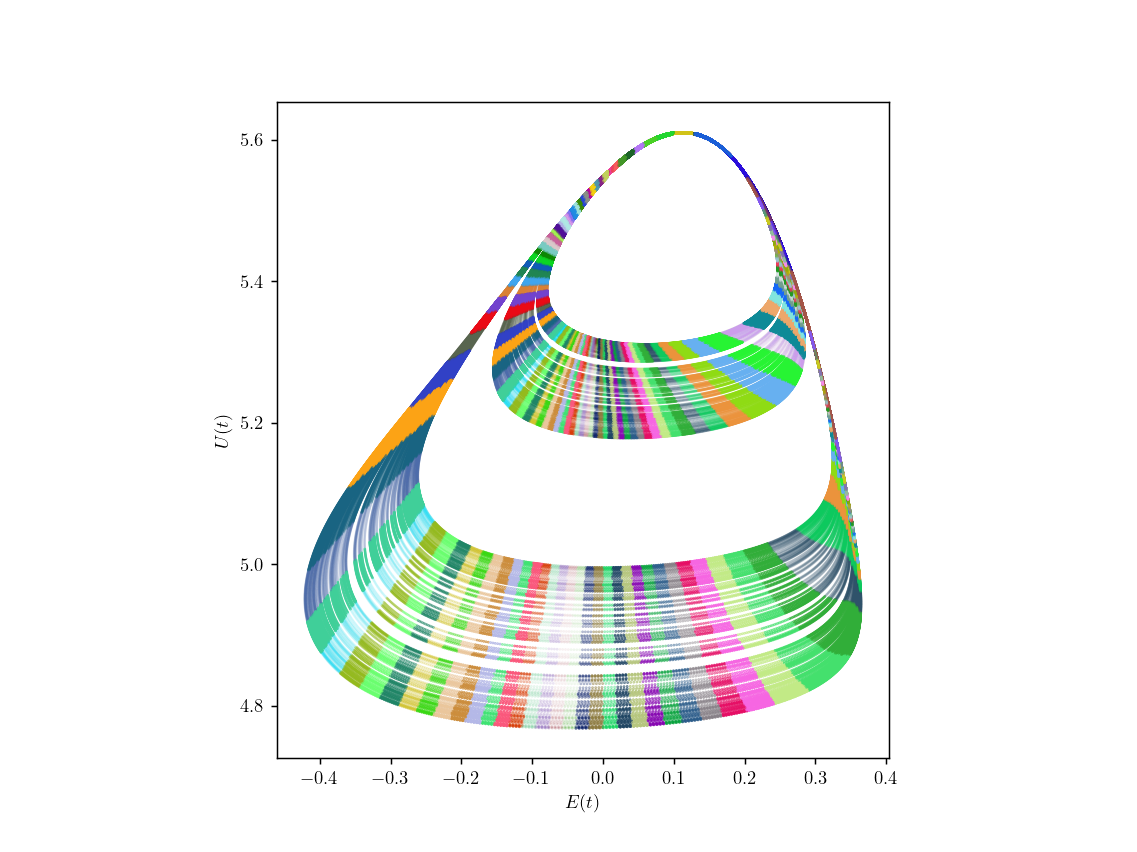

In [17]:
# geometric protophase theta_0 (on original attractor)

%matplotlib notebook
scatter(x[n0+k1+k2:n1,0],x[n0+k1+k2:n1,1],s=0.2,c=c0)
#plot(0,0,'rx')
axis('scaled')
xlabel(r'$E(t)$')
ylabel(r'$U(t)$')
show()

<IPython.core.display.Javascript object>


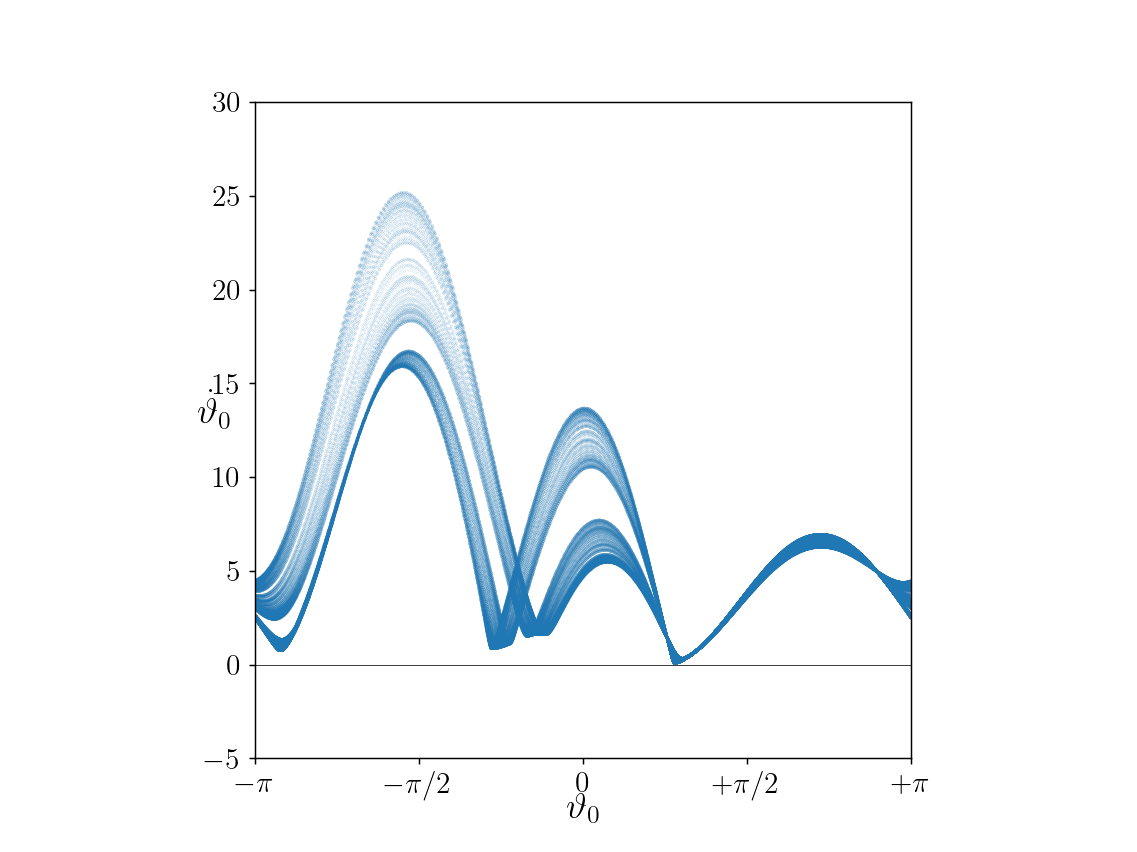

In [18]:
# velocity \dot\vartheta_0 of proto-phase as a function of \vartheta_0

%matplotlib notebook
fig,ax1 = subplots()
ax1.set_xlim(-pi,pi)
ax1.plot(th0,dth0,'.',markersize=0.1,alpha=0.8)
ax1.plot([-pi,pi],[0,0],'k',linewidth=0.4)
xlim(-pi,pi)
ylim(-5,30)
gca().set_aspect(2*pi/35)
gca().tick_params(labelsize=16)
xlabel(r'$\vartheta_0$',fontsize=20,labelpad=-5)
ylabel(r'$\dot\vartheta_0$',fontsize=20,labelpad=-5,rotation=0)

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])

show()

<IPython.core.display.Javascript object>


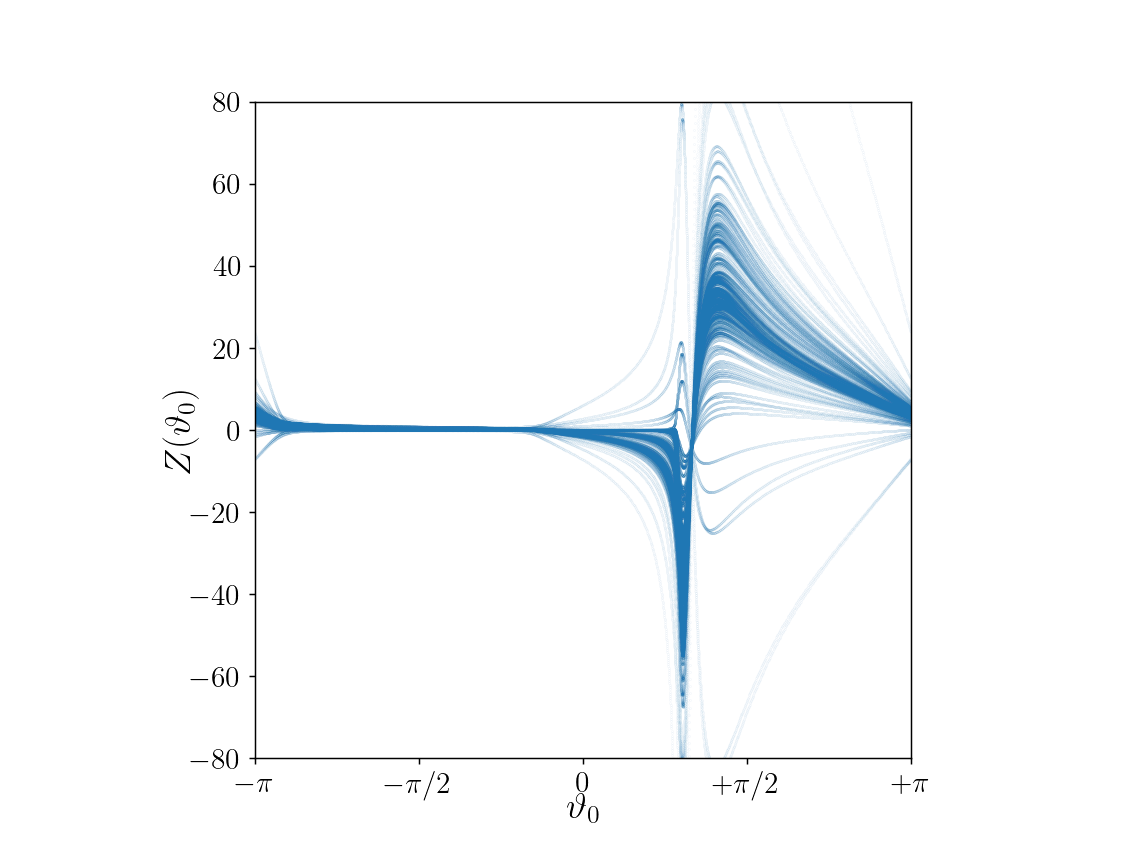

In [19]:
# phase sensitivity as a function of proto-phase
%matplotlib notebook
plot(th0,Z[k1+k2:,0],'.',markersize=0.1,alpha=0.4)
xlim(-pi,pi)
ylim(-80,80)
gca().set_aspect(2*pi/160)
gca().tick_params(labelsize=16)
xlabel(r'$\vartheta_0$',fontsize=20,labelpad=-5)
ylabel(r'$Z(\vartheta_0)$',fontsize=20,labelpad=-5,rotation=90)

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])

show()

In [20]:
print('calculating proto phase and phase velocity...')
th0 = WrapPhase(theta_0(xdel))
dth0 =dtheta_0(xdel,fdel)
print('Minimizing variance of phase velocity...')
sgm = MinimizeVarDth(kpar,xdel,fdel)
print('calculating optimized phase, phase velocity and gradient...')
th = WrapPhase(theta_sigma(kpar,sgm,xdel))
dth =dth_sigma(kpar,sgm,xdel,fdel)
gth = grad_th_sigma(kpar,sgm,xdel)
print('done.')

calculating proto phase and phase velocity...
Minimizing variance of phase velocity...
calculating optimized phase, phase velocity and gradient...
done.


In [21]:
# load pre-calculated optimized geometric phase 
# (same as used in the perturbation experiments)

*kparlist,sgmlist = np.loadtxt('kpar_del_export.txt',unpack=True)
kpar=[]
sgm=dict()
kparanz = len(kparlist[0])
for i in range(kparanz) :
    kpar.append((int(kparlist[0][i]),int(kparlist[1][i]),int(kparlist[2][i]),int(kparlist[3][i])))
    sgm[kpar[-1]]=sgmlist[i]
kpar=tuple(kpar)


print('calculating proto phase and phase velocity...')
th0 = WrapPhase(theta_0(xdel))
dth0 =dtheta_0(xdel,fdel)

print('calculating optimized phase, phase velocity and gradient...')
th = WrapPhase(theta_sigma(kpar,sgm,xdel))
dth =dth_sigma(kpar,sgm,xdel,fdel)
gth = grad_th_sigma(kpar,sgm,xdel)
print('done.')

calculating proto phase and phase velocity...
calculating optimized phase, phase velocity and gradient...
done.


<IPython.core.display.Javascript object>


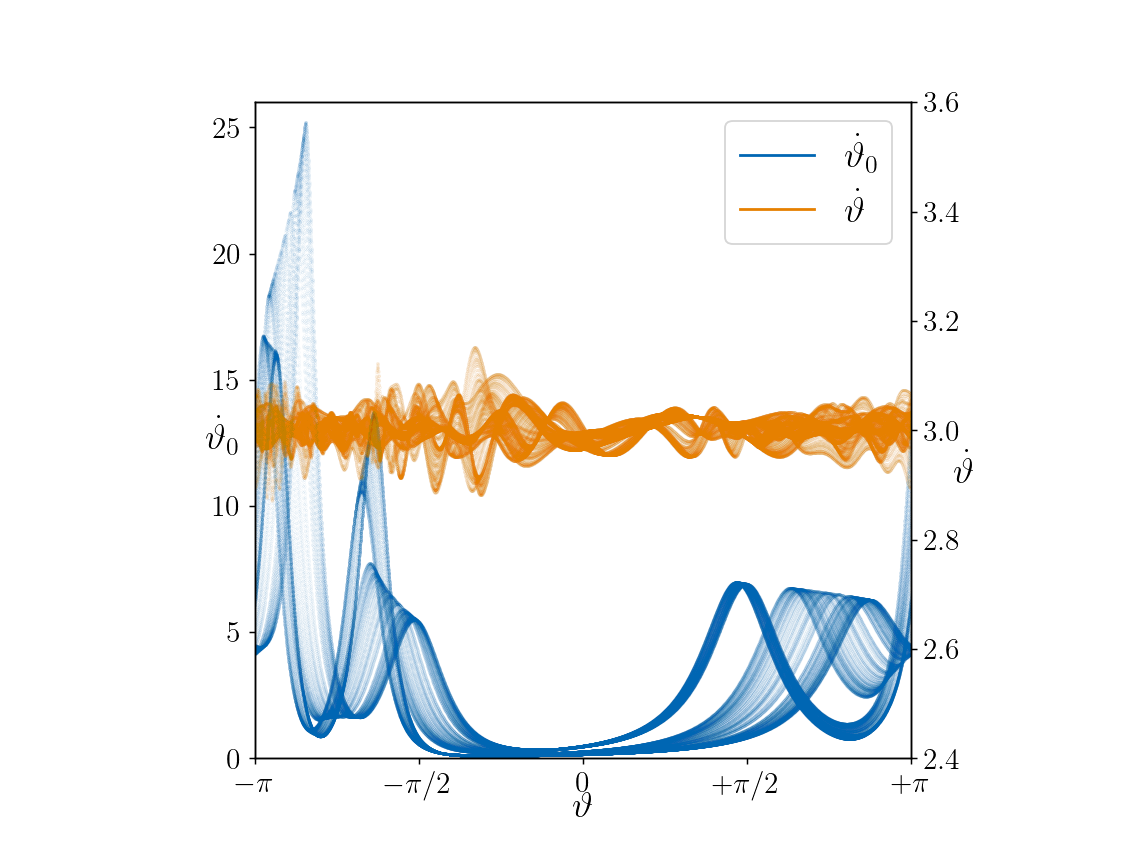

In [22]:
# velocities of proto-phase \vartheta_0 and optimized geometric phase \vartheta_\sigma 
# as a function of optimized phase

%matplotlib notebook
fig,ax1 = subplots()
ax1.set_xlim(-pi,pi)
ax2 = ax1.twinx()
ax1.plot(th,dth0,'.',markersize=0.1,color=[0,0.4,0.7],alpha=0.3,rasterized=True)
ax2.plot(th,dth,'.',markersize=0.1,alpha=0.3,color=[0.9,0.5,0],rasterized=True)

ax1.plot([0],[-1],'-',color=[0,0.4,0.7],label=r'$\dot\vartheta_0$')
ax1.plot([0],[-1],'-',color=[0.9,0.5,0],label=r'$\dot\vartheta$')

ax1.set_ylim(0,26)
ax2.set_ylim(2.4,3.6)

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

ax1.set_xlabel(r'$\vartheta$',fontsize=20,labelpad=-5)
ax1.set_ylabel(r'$\dot\vartheta_0$',fontsize=20,labelpad=-5,rotation=0)
ax2.set_ylabel(r'$\dot\vartheta$',fontsize=20,labelpad=-5,rotation=0)

ax1.yaxis.set_label_coords(-0.05,0.46) 
ax2.yaxis.set_label_coords(1.08,0.46) 

ax1.legend(fontsize=20)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])

show()

In [ ]:
savefig('OptimizedPhaseVelo.pdf',dpi=300,bbox_inches='tight')

In [23]:
mean(dth)

3.0011442190388276

In [24]:
std(dth)

0.027692078421734736

In [25]:
mean(dth0)

3.0041200259723846

In [26]:
std(dth0)

3.669337873769673

In [27]:
# create colormap for optimized geometric phase
L=len(th)
c=np.zeros((L,3))
nsec=100
for s in range(nsec) :
    sidx = np.nonzero((s*2*pi/nsec<=mod(th,2*pi)) * ((s+1)*2*pi/nsec>mod(th,2*pi)))    
    Zmean = mean(Z[k1+k2:,0][sidx])
    if Zmean>0 :
        c[sidx,2]= np.random.random(1)
        c[sidx,1] = np.random.random(1)*c[sidx,2]
        c[sidx,0]=0
    else :
        c[sidx,0]= np.random.random(1)
        c[sidx,1] = np.random.random(1)*c[sidx,0]
        c[sidx,2]=0

In [28]:
# optimized geometric phase on the attractor (delay embedding)
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xdel[:,0],xdel[:,1],xdel[:,2],c=c,s=1,cmap=c,alpha=0.4,rasterized=True)

ax.set_xlim(-0.45,0.4)
ax.set_ylim(-0.45,0.4)
ax.set_zlim(-0.45,0.4)
ax.set_box_aspect([1,1,1])

ax.set_xlabel(r'$E(t)$',fontsize=20)
ax.set_ylabel(r'$E(t-0.3)$',fontsize=20)
ax.set_zlabel(r'$E(t-0.6)$',fontsize=20)
ax.tick_params(labelsize=16)

show()

<IPython.core.display.Javascript object>

In [ ]:
savefig('KoperAttractorDelay.pdf',dpi=300,bbox_inches='tight')

In [29]:
# optimized geometric phase on the attractor (dynamic variables E, U and W)

%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[n0+k1+k2:n1,0],x[n0+k1+k2:n1,1],x[n0+k1+k2:n1,2],c=c,s=1,cmap=c,alpha=0.4,rasterized=True)

ax.set_xlim(-0.5,0.5)
ax.set_ylim(5.4-0.7,5.4+0.3)
ax.set_zlim(27-0.6,27+0.4)
ax.set_box_aspect([1,1,1])

ax.set_xlabel(r'$E$',fontsize=20)
ax.set_ylabel(r'$U$',fontsize=20)
ax.set_zlabel(r'$W$',fontsize=20)
ax.tick_params(labelsize=16)

show()

<IPython.core.display.Javascript object>

In [ ]:
savefig('KoperAttractor.pdf',dpi=300,bbox_inches='tight')

In [30]:
def GaussFilterFFT(x,sgm) :
    """
    convolution (periodic) of x_n with Gaussian averaging filter G(m,sgm)
    sgm is the standard deviation in data points for G
    """
    N=len(x)
    k=np.zeros(N)
    k[:N//2+1]=np.arange(N//2+1)
    k[N-1:N-1-N//2:-1]=k[1:N//2+1]
    
    Gk=exp(-(sgm*k/float(N))**2/2.0) # Gk[0]=1 -> normalized Gaussian kernel
    
    z = real(ifft(fft(x)*Gk))
    return z

In [31]:
idx = np.argsort(mod(th+pi,2*pi)-pi)
Zdel=Z[k1+k2:,0][idx]
Zdel.shape

(499400,)

In [32]:
# averaging of phase sensitivity with narrow Gaussian filter
Zsmooth = GaussFilterFFT(Zdel,500)

In [33]:
# load results of perturbation experiments (kicking phase (optimized) and shift of period)
Z1m3data = np.loadtxt('KickedPeriod_eps_1E-3.dat')
Z5m4data = np.loadtxt('KickedPeriod_eps_5E-4.dat')
Z1m4data = np.loadtxt('KickedPeriod_eps_1E-4.dat')


<IPython.core.display.Javascript object>


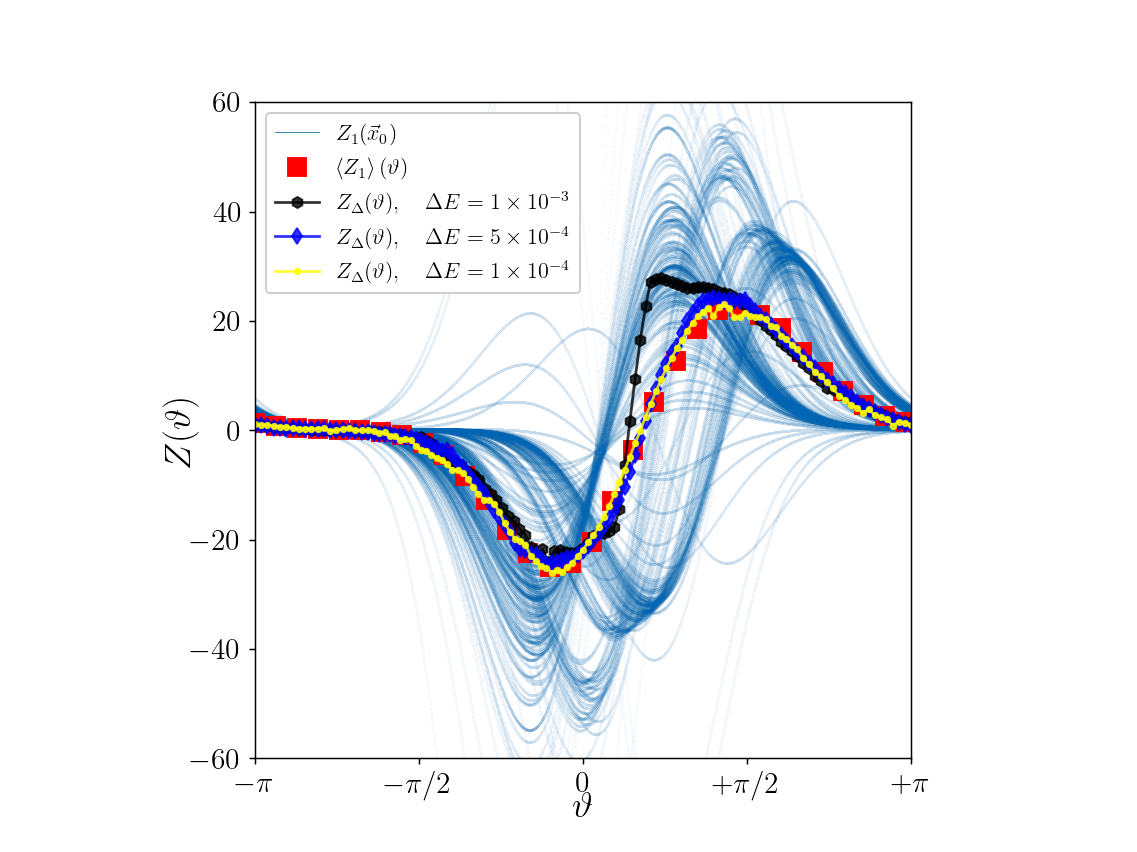

In [34]:
# comparizon of theory (Lyapunov vectors) and experiments (perturbations)
%matplotlib notebook
plot(-2,50,'-',color=[0,0.4,0.7],linewidth=0.4,label=r'$Z_1(\vec{x}_0)$')
plot(-2,50,'rs',markersize=10,alpha=1,label=r'$\left\langle Z_1\right\rangle(\vartheta)$')

delta_phi=0

plot(th,Z[k1+k2:,0],'.',color=[0,0.4,0.7],markersize=.1,alpha=0.4,rasterized=True)

plot(mod(th[idx][::16000]-delta_phi+pi,2*pi)-pi,Zsmooth[::16000],'rs',markersize=10,alpha=1)
plot(Z1m3data[:,0],Z1m3data[:,1]/0.001,'h-',c='k',label=r"$Z_\Delta(\vartheta),\quad  \Delta E = 1\times 10^{-3}$",alpha=0.8)
plot(Z5m4data[:,0],Z5m4data[:,1]/0.0005,'d-',c=[0,0,1],label=r"$Z_\Delta(\vartheta),\quad  \Delta E = 5\times 10^{-4}$",alpha=0.8)
plot(Z1m4data[:,0],Z1m4data[:,1]/0.0001,'.-',c=[1,1,0],label=r"$Z_\Delta(\vartheta),\quad  \Delta E = 1\times 10^{-4}$",alpha=0.8)
xlim(-pi,pi)
ylim(-60,60)
legend(loc='upper left',framealpha=1,fontsize=12)
gca().set_aspect(2*pi/120)
gca().tick_params(labelsize=16)
xlabel(r'$\vartheta$',fontsize=20,labelpad=-5)
ylabel(r'$Z(\vartheta)$',fontsize=20,labelpad=-5,rotation=90)

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
show()

In [ ]:
savefig('FrequencyResponse.pdf',dpi=300,bbox_inches='tight')

In [35]:
# Lyapunov exponents
print(mean(log(mu[n0:n1,:]),axis=0)/dphi)

[ 6.68794220e-02  1.98829907e-04 -2.52097172e+00]


<IPython.core.display.Javascript object>


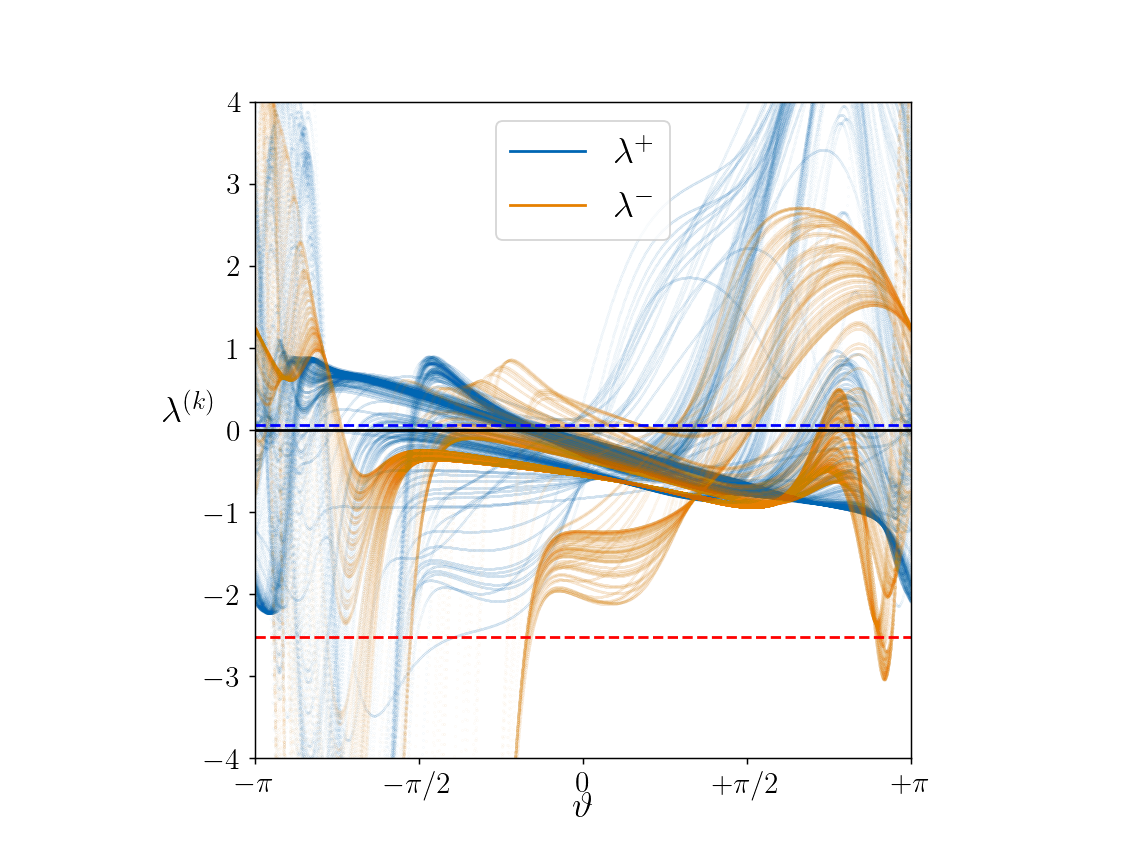

In [36]:
# plot local Lyapunov exponents 
# (unit Lyapunov vectors, i.e. the lambda_k are actual growth rates in units of the dynamic variables)
%matplotlib notebook
plot(th,log(mu[n0+k1+k2:n1,0])/dphi,'.',color=[0,0.4,0.7],alpha=0.3,markersize=0.1,rasterized=True)
plot(th,log(mu[n0+k1+k2:n1,2])/dphi,'.',color=[0.9,0.5,0],alpha=0.3,markersize=0.1,rasterized=True)

plot([0],[-1],'-',color=[0,0.4,0.7],label=r'$\lambda^{+}$')
plot([0],[-1],'-',color=[0.9,0.5,0],label=r'$\lambda^{-}$')

legend(fontsize=20,loc='best')


plot([-pi,pi],[0,0],'k-')
plot([-pi,pi],[mean(log(mu[n0:n1,0])/dphi),mean(log(mu[n0:n1,0])/dphi)],'b--')
plot([-pi,pi],[mean(log(mu[n0:n1,2])/dphi),mean(log(mu[n0:n1,2])/dphi)],'r--')
ylim(-4,4)
gca().tick_params(labelsize=16)
xlabel(r'$\vartheta$',fontsize=20,labelpad=-5)
ylabel(r'$\lambda^{(k)}$',fontsize=20,labelpad=8,rotation=0)
xlim(-pi,pi)
gca().set_aspect(2*pi/8)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])

show()

In [ ]:
savefig('LyapunovExponents.pdf',dpi=300,bbox_inches='tight')

In [39]:
# construct shadow trajactory and time isomorphism phase phi(t) for
# the oscillators kicked at a certain (optimized) phase
nanz=100000 # length of perturbation in time steps

Hk=np.zeros((nanz,3))
time = np.zeros(nanz)

eps=0.0001

p0=0          # geometric kicking phase
Hk[-1,0]=0
Hk[0,2]=0
time[0]=0

for t in range(0,nanz-1) :
    Hk[t+1,2]=Hk[t,2]*mu[n0+k1+k2+t,2]
    time[t+1]=time[t]+dphi           # time evolves as phase
    if (sin(th[t]-p0)*sin(th[t+1]-p0)<0) and (cos(th[t]-p0)>0) :
        time[t+1]-=dphi*eps*Z[k1+k2+t,0] # kick causes small adjustment of time
        Hk[t+1,2]+=eps*UT[n0+k1+k2+t,2,0] # E-component of Lyapunov co-vector for the stable direction


for t in range(nanz-1,0,-1) :
    Hk[t-1,0]=Hk[t,0]
    if (sin(th[t-1]-p0)*sin(th[t]-p0)<0) and (cos(th[t-1]-p0)>0) :
        Hk[t-1,0]-=eps*UT[n0+k1+k2+t-1,0,0] # E-component of Lyapunov co-vector for the unstable direction
    Hk[t-1,0]/=mu[n0+k1+k2+t-1,0]


In [40]:
# calculate shadow displacement h and amplitude |h|
H = einsum('ni,n->ni',V[n0+k1+k2:n0+k1+k2+nanz,:,0],Hk[:,0]) + einsum('ni,n->ni',V[n0+k1+k2:n0+k1+k2+nanz,:,2],Hk[:,2])
Habs = sqrt(einsum('ni,ni->n',H,H))

In [41]:
a0=0
a1=100000

<IPython.core.display.Javascript object>


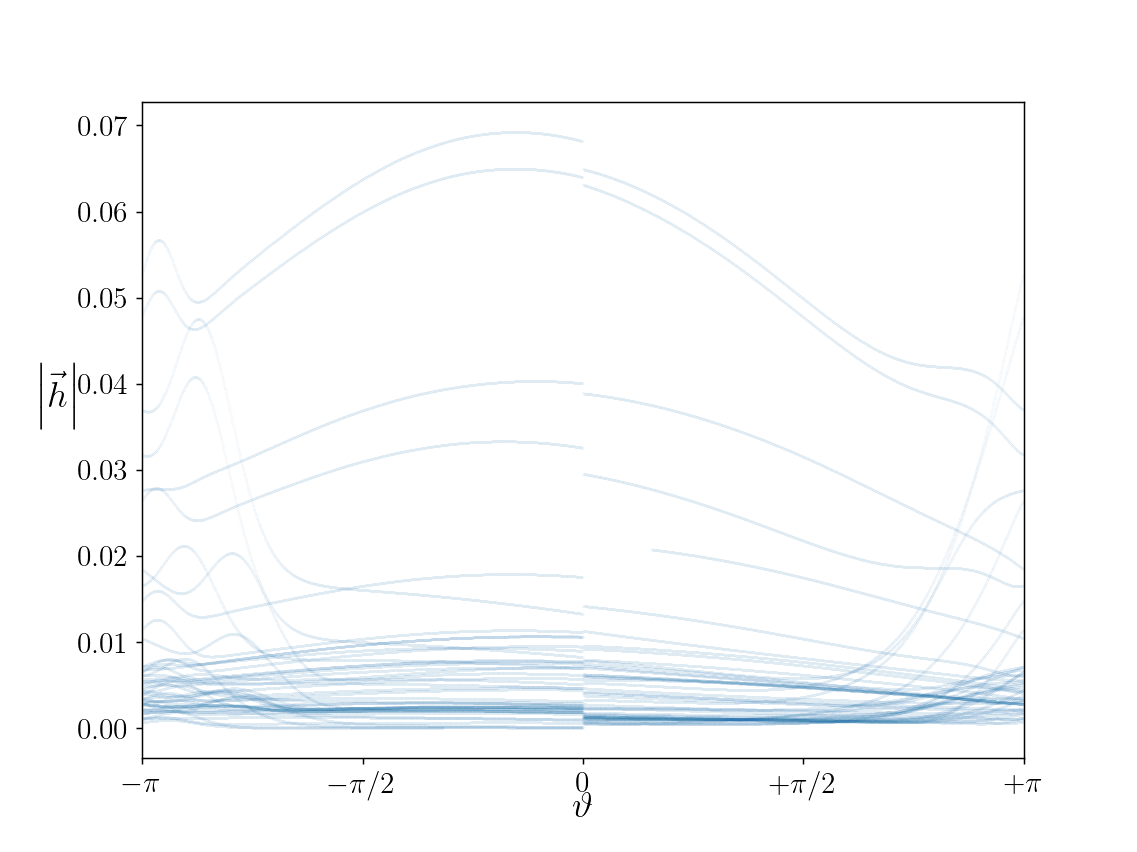

In [43]:
# plot deviation of the shadow trajectory from the unperturbed trajectory
%matplotlib notebook
plot(th[a0:a1],Habs[a0:a1],'.',markersize=0.1,alpha=0.3,rasterized=True)

gca().tick_params(labelsize=16)
xlabel(r'$\vartheta$',fontsize=20,labelpad=-5)
ylabel(r'$\left|\vec{h}\right|$',fontsize=20,labelpad=8,rotation=0)
xlim(-pi,pi)
#ylim(0,0.04)
#gca().set_aspect(2*pi/0.036)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
show()

In [ ]:
savefig('ShadowDist.pdf',dpi=300,bbox_inches='tight')

<IPython.core.display.Javascript object>


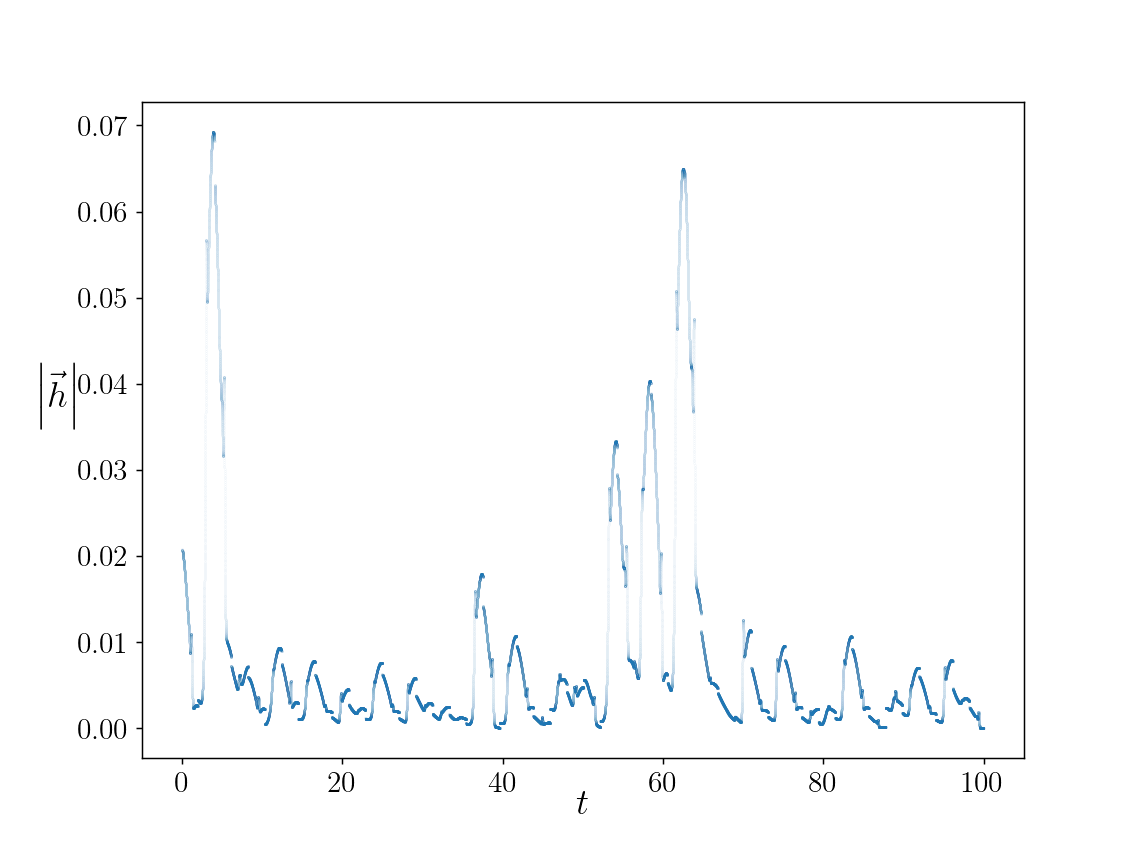

In [45]:
# plot deviation of the shadow trajectory from the unperturbed trajectory
%matplotlib notebook
plot(time[a0:a1],Habs[a0:a1],'.',markersize=0.1,alpha=0.3,rasterized=True)

gca().tick_params(labelsize=16)
xlabel(r'$t$',fontsize=20,labelpad=-5)
ylabel(r'$\left|\vec{h}\right|$',fontsize=20,labelpad=8,rotation=0)
#xlim(-pi,pi)
#ylim(0,0.04)
#gca().set_aspect(2*pi/0.036)
#plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
show()

In [47]:
(time[-1]-nanz*dphi)/eps

-8.938924097066092